In [284]:
import os
import warnings
import time

import numpy as np 

from scipy.stats import chisquare

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std, gaussian_sigma_to_fwhm
from astropy.table import Table
from astropy.modeling import models, fitting, functional_models, Parameter, custom_model
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.utils.exceptions import AstropyWarning
from astropy import units as u
from astropy.convolution import convolve
from astropy import units as u 

from astropy.stats import gaussian_fwhm_to_sigma

from photutils import detect_threshold
from photutils import deblend_sources
from photutils import source_properties
from photutils import detect_sources
from photutils import source_properties, EllipticalAperture

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import SigmaClip

from photutils import Background2D, MedianBackground
from photutils import DAOStarFinder
from photutils import aperture_photometry, CircularAperture, CircularAnnulus, EllipticalAnnulus

In [285]:
from lcbg.utils import cutout, measure_fwhm, plot_apertures, angular_to_pixel
from lcbg.fitting import plot_fit, fit_model, model_subtract, Moffat2D, Nuker2D
from lcbg.segmentation import plot_segment_residual, plot_segments, make_segments, deblend_segments
from lcbg.photometry import flux_to_abmag, order_cat
from lcbg.cosmology import cosmo_aperture_diameter


In [286]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.figsize'] = [12, 12]

In [287]:
import ipywidgets as widgets
from IPython.display import display

# Define Paths

In [288]:
filter_list = ['f105w', 'f125w', 'f140w', 'f160w']

In [289]:
input_data_formatter = "https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0-epoch1/hlsp_frontier_hst_wfc3-60mas_abell2744_{}_v1.0_drz.fits"

# Determine a Good Cutout Coord for Noise Estimate

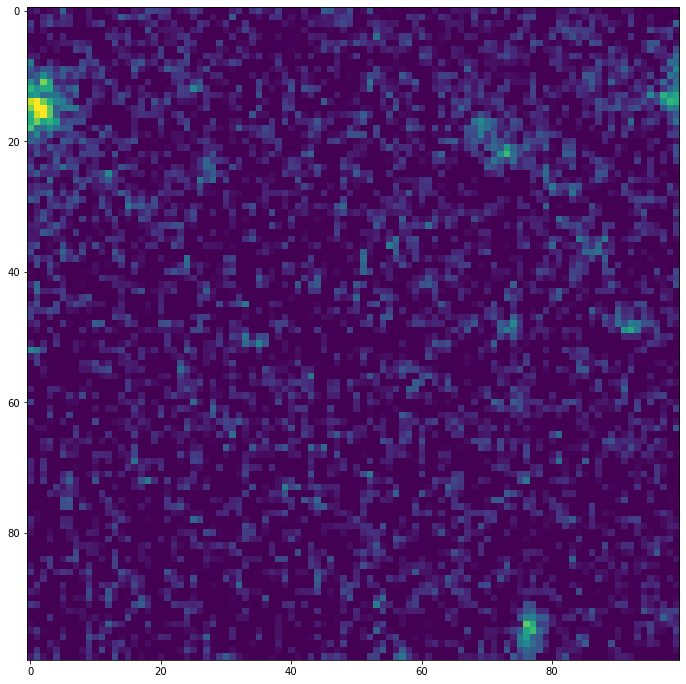

In [290]:
input_data_path = input_data_formatter.format('f105w')

hdul = fits.open(input_data_path)
hdu = hdul[0]

data = hdu.data
header = hdu.header
wcs = WCS(header)

subsection = cutout(data, 2779, 3390,  100)
plt.imshow(subsection, vmin=0, vmax=2.9534784e-05*350)


# Do Aperture Photomerty

In [349]:
for current_filter in  filter_list:
    print(current_filter)
    
    # Load data and vitals
    # ---------------------
    
    input_data_path = input_data_formatter.format(current_filter)
    output_path = "{}_catalog.csv".format(os.path.splitext(os.path.basename(input_data_path))[0])

    hdul = fits.open(input_data_path)
    hdu = hdul[0]

    data = hdu.data
    header = hdu.header
    wcs = WCS(header)

    
    # Cutout Image
    # ------------
    
    # Estimate data noise
    subsection = cutout(data, 2779, 3390,  150)
    mean_noise = subsection.mean()
    
    # Select and crop image:
    cx, cy = [int(np.round(i)) for i in wcs.world_to_pixel_values(header["RA_TARG"], header["DEC_TARG"])]
    image = cutout(data, cx, cy, 1000)
    
    image_wcs = wcs.copy()
    delta_pix = np.array([cx, cy]) - np.array(image.shape)//2
    image_wcs.wcs.crpix = np.array(image_wcs.wcs.crpix) - delta_pix
    
    image -= mean_noise
    image = np.clip(image, 0, image.max())
    

    # Catalog
    # -------
    
    #nsigma = np.zeros_like(image) + image.mean() / 3
    nsigma = np.unique(detect_threshold(image, nsigma=3.))[0]
    segm = make_segments(image, nsigma=nsigma, kernel_size=None)
    
    segm_deblend = deblend_segments(image, segm)
    #plot_segments(segm_deblend, image)
    
    segm_deblend.remove_border_labels(50)

    cat = source_properties(image, segm_deblend, wcs=image_wcs)
    
    # Photomerty
    # ----------
    plot = False
    r_list = list(range(1, 41, 1))
    #r_list = np.logspace(np.log10(0.06),np.log10(14), 50) * u.arcsec # approximate isophotal extent
    #r_list = angular_to_pixel(r_list, wcs=wcs) # convert to pixels
    #r_list = np.unique(np.round(r_list).astype(int)) # convert to int 

    single_aperture_photometry_table = cat.to_table()

    aperture_photometry_rows = []

    pb = widgets.IntProgress(
        value=0,
        min=0,
        max=len(cat),
        step=1,
        description='Loading:',
        bar_style='',
        orientation='horizontal'
    )

    display(pb)

    for idx, obj in enumerate(cat):
        pb.value = idx + 1
        pb.description = "{}/{}".format(pb.value, len(cat))
        
        cut = obj.segment.make_cutout(image, masked_array=True)
        cy, cx = np.unravel_index(cut.argmax(), cut.shape)

        x = obj.segment.bbox.ixmin + cx
        y = obj.segment.bbox.iymin + cy

        #x = obj.xcentroid.value
        #y = obj.ycentroid.value
        single_aperture_photometry_table[idx]['xcentroid'] = x * u.pix
        single_aperture_photometry_table[idx]['ycentroid'] = y * u.pix

        position = np.transpose((x, y))
        
        mask = ((segm_deblend.data == 0 ) | (segm_deblend.data == obj.id))
        masked_image = image.copy()
        masked_image[np.invert(mask)] = np.nan

        annulus = CircularAnnulus(position, r_list[-1], r_list[-1]*2)

        annulus_mask = annulus.to_mask(method='center')
        annulus_data = annulus_mask.multiply(masked_image)
        annulus_data_1d = annulus_data[(annulus_mask.data > 0) & (np.invert(np.isnan(annulus_data)))]
        _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
        
        masked_image[np.invert(mask)] =  median_sigclip

        aperture_photometry_row = []

        if plot:
            f, ax = plt.subplots(1, 1)
        for i, r in enumerate(r_list):

            aperture = CircularAperture(position, r)

            photometric_sum = aperture.do_photometry(masked_image, mask=None)[0][0] 
            
            #photometric_bkg = aperture.area * (annulus.do_photometry(masked_image)[0][0] / annulus.area)
            photometric_bkg = median_sigclip * aperture.area

            photometric_value = photometric_sum - photometric_bkg

            if plot:
                ax.imshow(masked_image, vmin=0, vmax=image.mean())
                aperture.plot(ax, color='r')

            aperture_photometry_row.append(photometric_value)
        if plot:
            plt.show()

        aperture_photometry_rows.append(np.array(aperture_photometry_row))

    single_aperture_photometry_table.add_columns(np.transpose(aperture_photometry_rows), names=["aperture_sum_{:0>3}".format(r) for r in r_list])

    single_aperture_photometry_table.sort(keys="source_sum", reverse=1)
    single_aperture_photometry_table.write(output_path, format="ascii.csv", overwrite=True)
    plt.show()
    break
print("done")

f105w


IntProgress(value=0, description='Loading:')

done


In [350]:
cat = Table.read(output_path)
cat.sort(keys="source_sum", reverse=1)

In [351]:
import re

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

mag_col_names = natural_sort([i for i in cat.colnames if "aperture_sum_" in i])

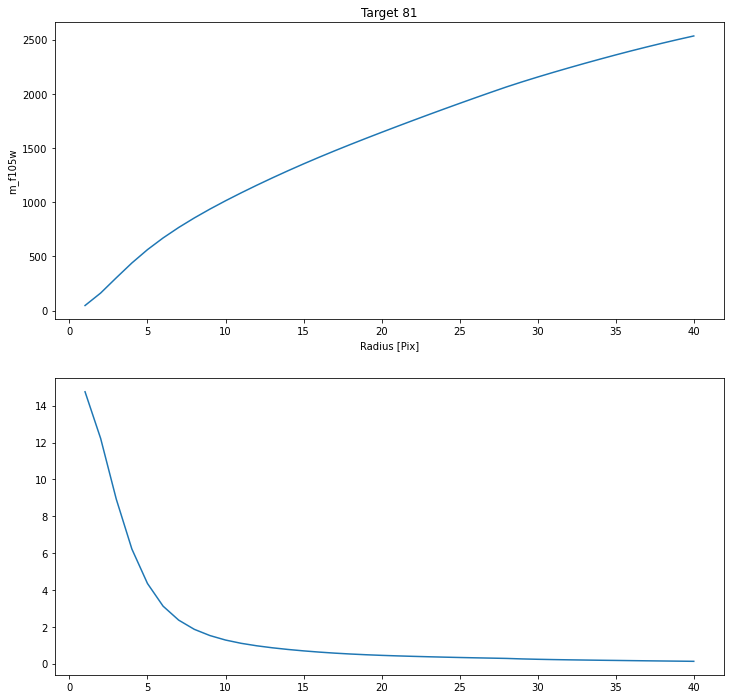

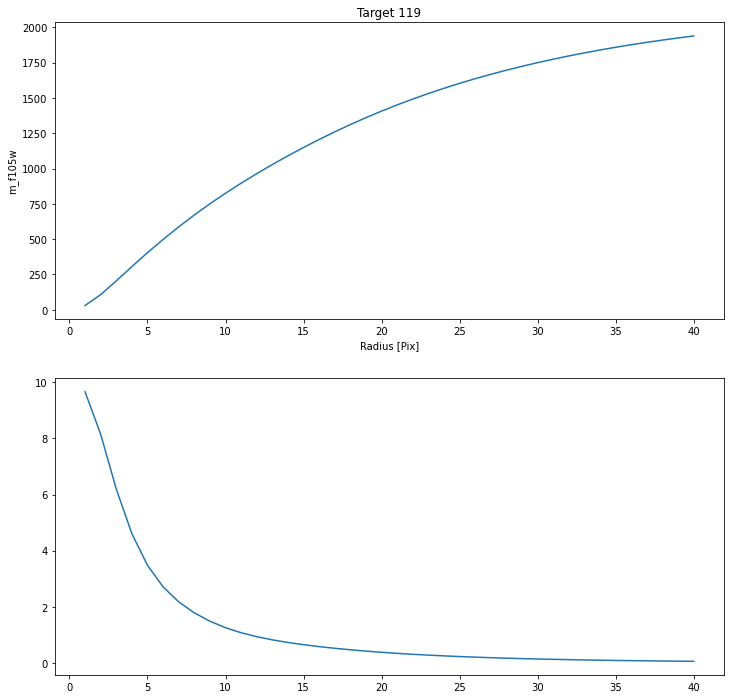

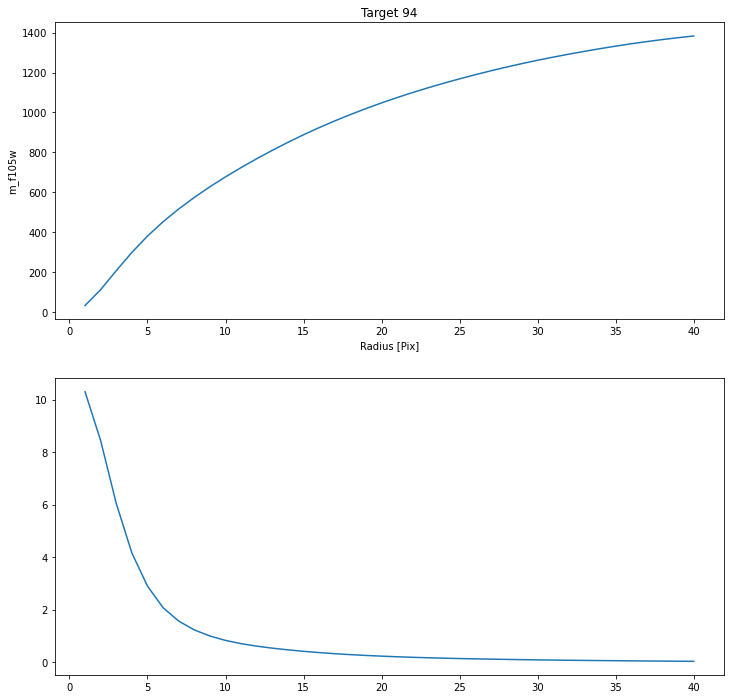

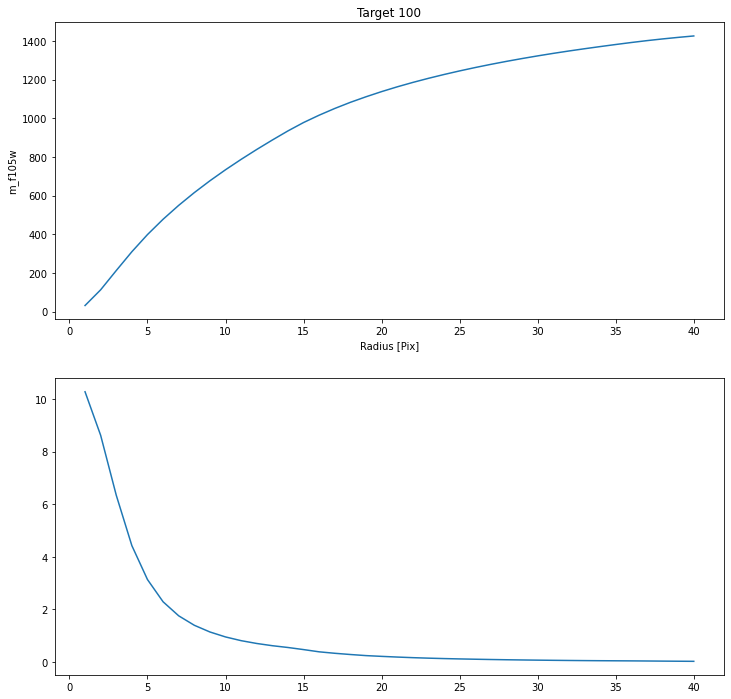

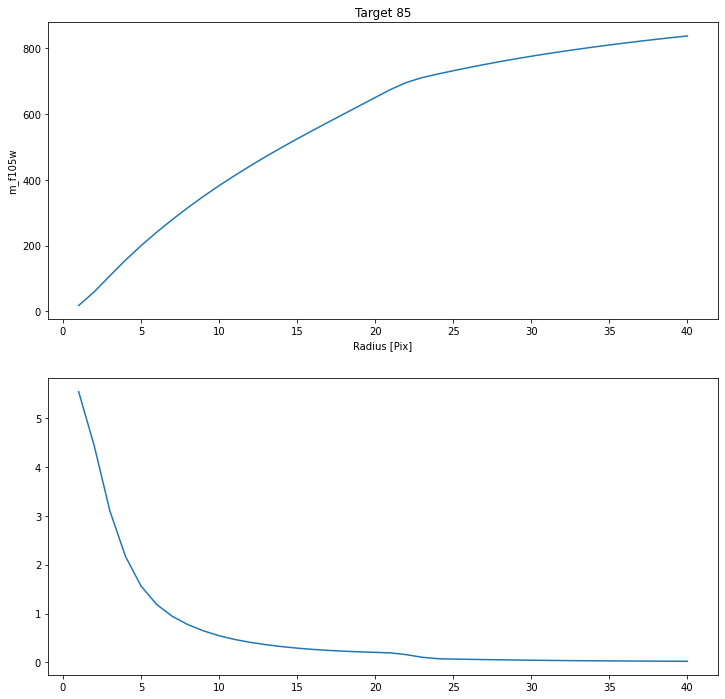

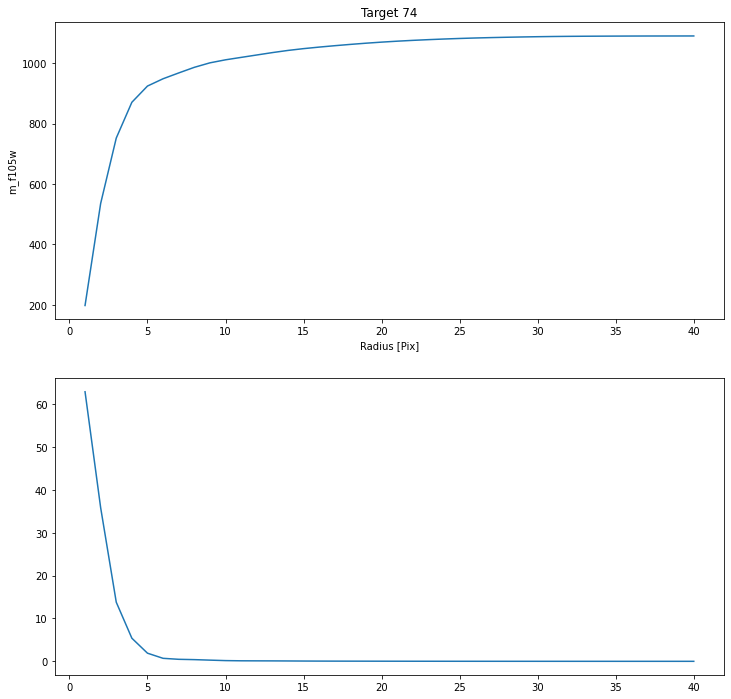

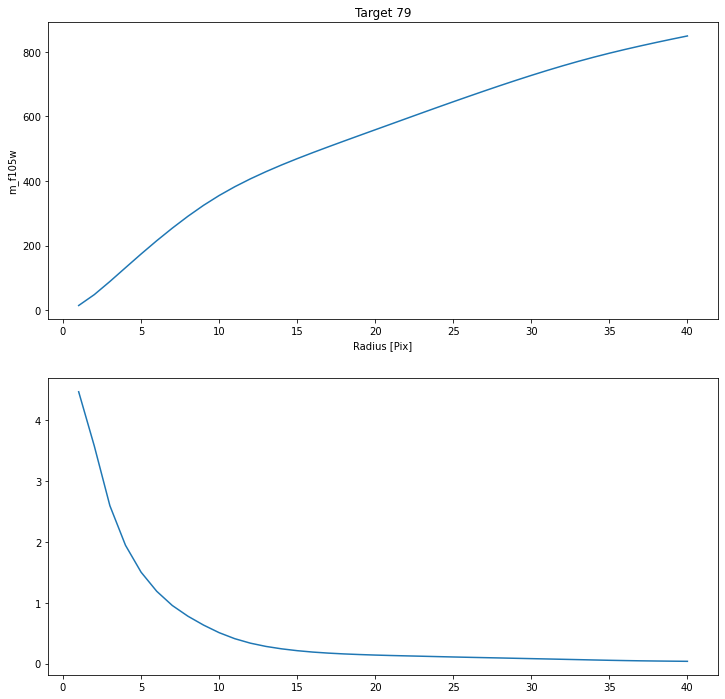

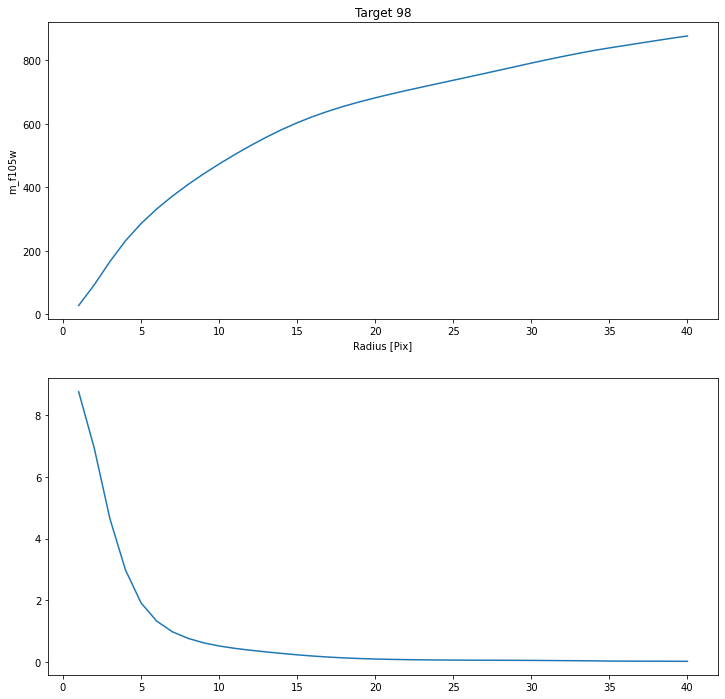

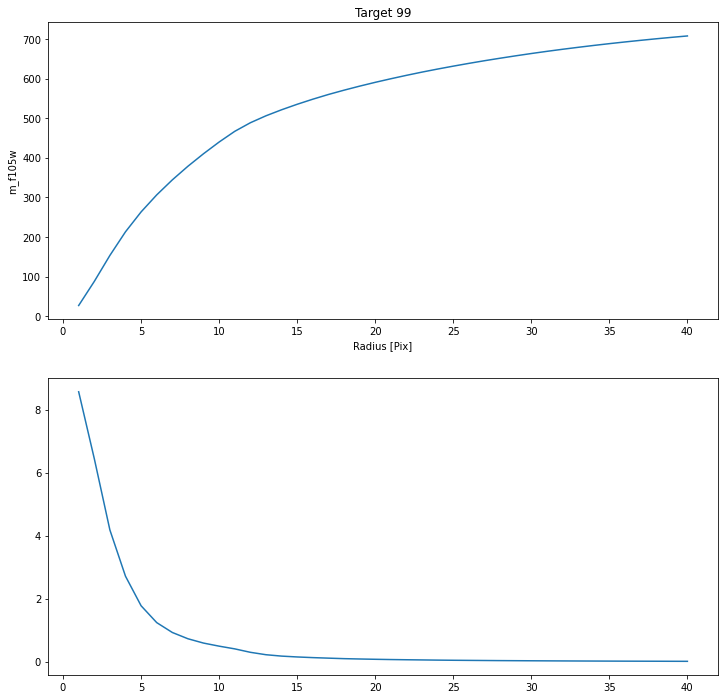

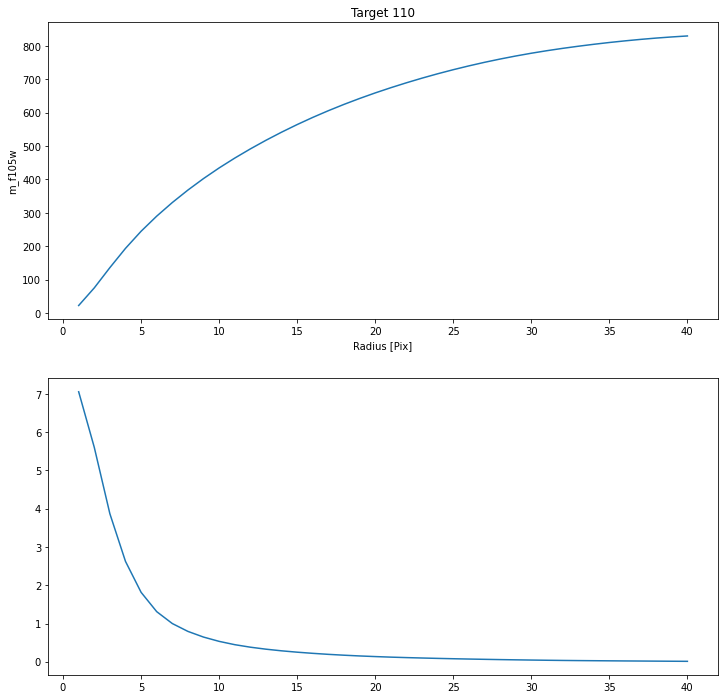

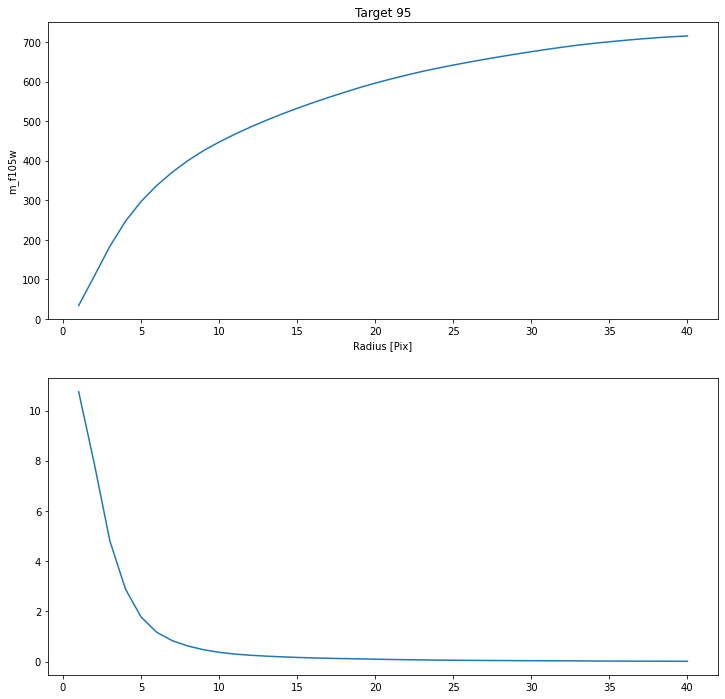

In [352]:
for idx, row in enumerate(cat):
    mags = list(row[mag_col_names])
    
    f, ax = plt.subplots(2, 1)
    
    ax[0].plot(r_list, mags)
    ax[0].set_title("Target "+str(row['id']))
    ax[0].set_xlabel("Radius [Pix]")
    ax[0].set_ylabel("m_f105w")
    
    y_values = []
    for i in range(len(mags)):
        if i == 0:
            y_values.append(mags[i]/(np.pi*r_list[i]**2))
            continue
        y_values.append((mags[i] - mags[i-1])/(np.pi*(r_list[i]**2-r_list[i-1]**2)))    
    ax[1].plot(r_list, y_values, label="Raw")
    plt.show()
    if idx == 10:
        break
    print("\n"*2)

In [353]:
phot_table = cat
radii = r_list
radii[-1]

40

In [354]:
def slider(x):
    cutout_size = int(round(radii[-1]*2))
    
    row = phot_table[x]
    
    target = cutout(image, 
                    int(round(row['xcentroid'])), 
                    int(round(row['ycentroid'])),
                    cutout_size)
    
    mask = ((segm_deblend.data == 0 ) | (segm_deblend.data == row['id']))
    masked_image = image.copy()
    masked_image[np.invert(mask)] = np.nan
    
    masked_target = cutout(masked_image, 
                    int(round(row['xcentroid'])), 
                    int(round(row['ycentroid'])),
                    cutout_size)
    
    cutout_size = target.shape[0]
    
    # Plot Target
    # -----------
    
    f, ax = plt.subplots(2, 2)

    ax[0,0].imshow(target, vmin=vmin, vmax=vmax)
    ax[0,0].set_title("Target".format(vmax))
    
    ax[0,1].imshow(np.clip(masked_target, 0, target.max()), vmin=vmin, vmax=vmax)
    ax[0,1].set_title("Target [Masked Image]")    
    
    position = [np.transpose((cutout_size//2, cutout_size//2))]
    
    for r in radii:
        CircularAperture(position, r=r).plot(ax[0,0], color='w')
        CircularAperture(position, r=r).plot(ax[0,1], color='w')
    CircularAnnulus(position, r_in=radii[-1], r_out=radii[-1]*2).plot(ax[0,0], color='r')
    CircularAnnulus(position, r_in=radii[-1], r_out=radii[-1]*2).plot(ax[0,1], color='r')
    
    # Plot Cumulative Photometry
    # --------------------------
    
    y_values = list(row[mag_col_names])
    ax[1,0].plot(radii, y_values, label="Raw")
    
    ax[1,0].set_title("Cumulative Photometry")
    ax[1,0].set_xlabel("Aperture Radius [Pix]")
    ax[1,0].set_ylabel("Photometic Sum")
    
    ax[1,0].legend()
    
    # Plot Photometic Density
    # -----------------------
    
    y_values = []
    phot_values = list(row[mag_col_names])
    for i in range(len(phot_values)):
        if i == 0:
            y_values.append(phot_values[i]/(np.pi*r_list[i]**2))
            continue
        y_values.append((phot_values[i] - phot_values[i-1])/(np.pi*(r_list[i]**2 - r_list[i-1]**2)))    
    ax[1,1].plot(radii, y_values, label="Raw") 
  
    ax[1,1].set_title("Photometic Density: sum(slice) / area(slice)")
    ax[1,1].set_xlabel("Aperture Radius [Pix]")
    ax[1,1].set_ylabel("Photometic Sum")
    ax[1,1].axhline(0, c='black', label="Zero Level")
    ax[1,1].legend()
    
    plt.show()
    
    cutout_size = radii[-1] * 2
    target = cutout(masked_image, 
                    int(round(phot_table[x][1])), 
                    int(round(phot_table[x][2])),
                    cutout_size)
    
    position = [np.transpose((cutout_size//2, cutout_size//2))]
    
    plt.imshow(target)
    for r in radii:
        CircularAperture(position, r=r).plot(plt.gca(), color='w')
    CircularAnnulus(position, r_in=radii[-1], r_out=radii[-1]*2).plot(plt.gca(), color='r')


    plt.show()

vmin = 0
vmax = image.mean()*100
#widgets.interact_manual(slider, x=widgets.IntSlider(min=0, max=len(phot_table)-1));
widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(phot_table)-1));

interactive(children=(BoundedIntText(value=0, description='x', max=99), Output()), _dom_classes=('widget-inter…

In [367]:
def slider(x):
    def petrosian(i):
        return (row[i]-row[i-1]) / (row[i]/(np.pi * r_list[i]**2))
    row = phot_table[x][mag_col_names]

    p_list = []
    for i, names in enumerate(mag_col_names):
        if i == 0:
            continue
        p_list.append(petrosian(i))
    plt.plot(r_list[1:], p_list)
    
widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(phot_table)-1));


interactive(children=(BoundedIntText(value=0, description='x', max=99), Output()), _dom_classes=('widget-inter…

In [355]:
#plot_segments(segm_deblend, image, vmax=image.mean()*6)

In [356]:
angular_diameter = 14*u.arcsec
pixel_scales = proj_plane_pixel_scales(wcs)
assert np.allclose(*pixel_scales)
pixel_scale = pixel_scales[0] * wcs.wcs.cunit[0] / u.pix

pixel_size = angular_diameter / pixel_scale.to(angular_diameter.unit / u.pix)
pixel_size = pixel_size.value
pixel_size


NameError: name 'proj_plane_pixel_scales' is not defined

In [ ]:
angular_to_pixel(angular_diameter, wcs)

In [22]:
r_list =# * u.arcsec 
r_list

array([ 0.06      ,  0.06706212,  0.07495548,  0.08377789,  0.09363872,
        0.10466019,  0.11697892,  0.13074758,  0.14613684,  0.16333745,
        0.1825626 ,  0.2040506 ,  0.22806778,  0.25491183,  0.28491548,
        0.31845062,  0.35593292,  0.39782697,  0.44465202,  0.49698849,
        0.55548507,  0.62086681,  0.69394412,  0.77562278,  0.86691519,
        0.96895291,  1.08300068,  1.2104721 ,  1.35294718,  1.51219187,
        1.69017999,  1.88911768,  2.11147075,  2.35999524,  2.63777157,
        2.94824275,  3.29525704,  3.68311563,  4.11662598,  4.60116139,
        5.14272763,  5.74803734,  6.42459326,  7.18078121,  8.02597405,
        8.97064785, 10.02651171, 11.20665293, 12.52569922, 14.        ])

# Compare Catalogs

In [112]:
astro_deep_cat = Table.read("https://stsci.box.com/shared/static/2dsckrbt7b4eocl2v2mot9ssso0stc11.cat", format="ascii")

Mean[MAG_Y105]: -0.032826992449564524
Mean[MAG_J125]: -0.028791166160849133
Mean[MAG_JH140]: -0.058600086241409326
Mean[MAG_H160]: -0.05613464998700826


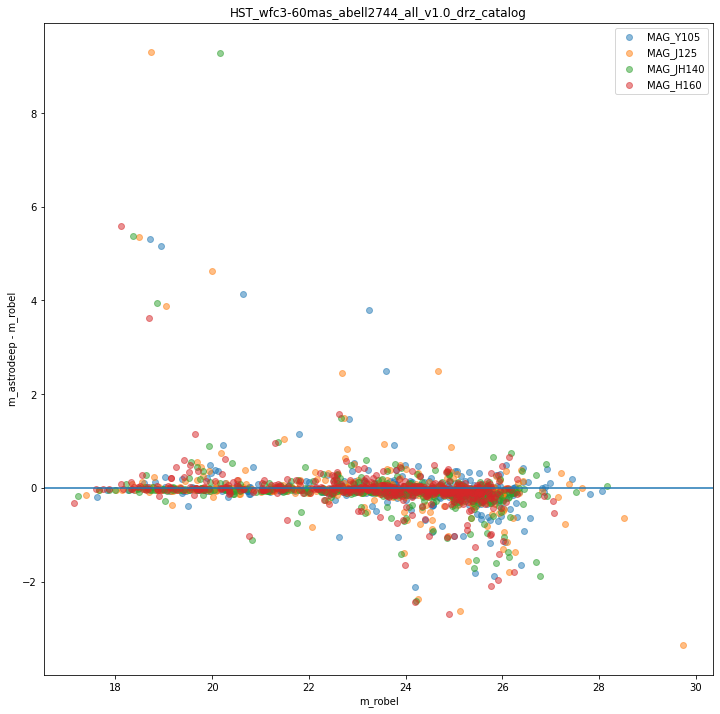

In [117]:
coords = []
for filt, ad_filt in zip(filter_list, ad_filter_list):
    cat = Table.read("hlsp_frontier_hst_wfc3-60mas_abell2744_{}_v1.0_drz_catalog.csv".format(filt), format='ascii.csv')
    
    ad_values = []
    cat_values = []
    for row in cat:
        ra, dec = [float(i) for i in row['sky_centroid'].split(',')]
        mag = row['ab_mag']

        coord_delta = ((astro_deep_cat['RA'] - ra)**2 + (astro_deep_cat['DEC'] - dec)**2)
        idx = coord_delta.argmin()
        
        if coord_delta[idx] > 1e-8:
            continue
        
        ad_mag = astro_deep_cat[idx][ad_filt]

        if ad_mag < 99 and  -10 < (ad_mag - mag) < 10:
            ad_values.append(ad_mag - mag)
            cat_values.append(mag)
            
    plt.scatter(cat_values, ad_values, alpha=0.5, label=ad_filt)
    print("Mean[{}]:".format(ad_filt), np.array(ad_values).mean())
            
plt.axhline(0)
plt.legend()
plt.title("HST_wfc3-60mas_abell2744_all_v1.0_drz_catalog")
plt.xlabel("m_robel")
plt.ylabel("m_astrodeep - m_robel");

#plt.savefig('HST_wfc3-60mas_abell2744_all_v1.0_drz_catalog.png', dpi=500)

In [331]:
import matplotlib.patches as patches
from PIL import Image

In [345]:
def slider(x):
    mask = ((segm_deblend.data == 0 ) | (segm_deblend.data == cat[x]['id']))
    masked_image = image.copy()
    masked_image[np.invert(mask)] = np.nan
    plt.imshow(masked_image, vmax=image.mean()*10, vmin=0)

    # Create catalog Rectangle
    size = masked_image.shape[0]
    rect = patches.Rectangle([50,50], size-100, size-100,linewidth=10,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    plt.gca().add_patch(rect)
widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(phot_table)-1));

interactive(children=(BoundedIntText(value=0, description='x', max=99), Output()), _dom_classes=('widget-inter…

In [209]:
r_list = np.logspace(np.log10(0.06),np.log10(14), 50) * u.arcsec # approximate isophotal extent
r_list = angular_to_pixel(r_list, wcs=wcs) # convert to pixels
#r_list = np.unique(np.round(r_list).astype(int)) # convert to int 
r_list

array([  1.00000019,   1.11770228,   1.24925816,   1.39629843,
         1.56064566,   1.74433689,   1.94964896,   2.17912668,
         2.43561441,   2.72229128,   3.04271061,   3.40084396,
         3.80113035,   4.24853127,   4.74859222,   5.30751137,
         5.93221647,   6.63045065,   7.41086844,   8.28314303,
         9.25808614,  10.34778208,  11.5657375 ,  12.92704879,
        14.44858924,  16.14921816,  18.05001464,  20.1745388 ,
        22.54912386,  25.20320251,  28.16967171,  31.4853005 ,
        35.19118567,  39.33326122,  43.96286764,  49.13738835,
        54.92096087,  61.38527188,  68.6104457 ,  76.68603746,
        85.71214312,  95.80064015, 107.07657419, 119.67970906,
       133.76625904, 149.51082518, 167.1085594 , 186.77758344,
       208.7616924 , 233.33337659])

In [247]:
np.unique(np.round(r_list).astype(int))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       20, 22, 24, 26, 28, 31, 34, 37, 40, 43, 47, 52, 56, 61, 67])